In [3]:
import pandas as pd

def process(text: str):
    from parse import compile
    from string import punctuation

    p = compile("{hit:d}.")
    in_list = text.split()
    out_list = list()
    for seg in in_list:
        parse_result = p.parse(seg)
        if parse_result:
            # We got a number with a dot afterward:
            out_list.append(seg.lower())
        else:
            out_list.append(seg.translate(str.maketrans("", "", punctuation)).lower())
    return " ".join(out_list)



df = pd.read_json("ParlaSpeech-HR.v1.0.jsonl", orient="records", lines=True)
df["audio_length"] = df.end-df.start
df = df[df.audio_length >= 8]
df = pd.concat([df, df.speaker_info.apply(pd.Series)], axis=1)
df.head(3)

,path,orig_file,start,end,words,word_start_times,norm_words,norm_words_start_times,utterance_id_start,utterance_id_end,...,norm_words_edited,audio_length,Speaker_role,Speaker_type,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth
0,rFVDr4ghXlQ_10620.07-10632.05.wav,"20 2 2020 - 1. dio, 16. sjednica, 9. saziv [rF...",10620.07,10632.05,"[interpretacija,, inzistiranje, na, tim, dezin...","[0, 1.0, 1.83, 1.96, 2.22, 3.79, 4.01, 4.43, 5...","[interpretacija, inzistiranje, na, tim, dezinf...","[0, 1.0, 1.83, 1.96, 2.22, 3.79, 4.01, 4.43, 5...",ParlaMint-HR_S16.u4568,ParlaMint-HR_S16.u4568,...,NaN,11.98,Regular,MP,HDZ,Klub Hrvatske demokratske zajednice,Coalition,"Tuđman, Miroslav",M,1946
1,Ki_SnDM_EkQ_2917.58-2937.5.wav,"18 10 2018 - 9. sjednica, 9. saziv [Ki_SnDM_Ek...",2917.58,2937.50,"[izraelska, tvrtka, prodaje, avione, Hrvatskoj...","[0, 0.65, 1.04, 1.54, 1.92, 2.51, 3.11, 3.5700...","[izraelska, tvrtka, prodaje, avione, hrvatskoj...","[0, 0.65, 1.04, 1.54, 1.92, 2.51, 3.11, 3.5700...",ParlaMint-HR_S09.u4267,ParlaMint-HR_S09.u4267,...,NaN,19.92,Regular,MP,"Živi zid, SNAGA",Klub Živog zida i SNAGA-e,Opposition,"Bunjac, Branimir",M,1972
2,XguZsDKdRh4_13797.59-13811.74.wav,"20 1 2017 - 3. sjednica, 9. saziv [XguZsDKdRh4...",13797.59,13811.74,"[jučer, trećem,, sutra, ili, prekosutra, četvr...","[0, 0.43, 1.0, 1.4, 1.52, 2.01, 2.55, 3.12, 3....","[jučer, trećem, sutra, ili, prekosutra, četvrt...","[0, 0.43, 1.0, 1.4, 1.52, 2.01, 2.55, 3.12, 3....",ParlaMint-HR_S03.u9702,ParlaMint-HR_S03.u9702,...,NaN,14.15,Regular,MP,HDZ,Klub Hrvatske demokratske zajednice,Coalition,"Bačić, Branko",M,1959


In [4]:

from datetime import datetime
def get_date_from_filename(s: str)->datetime:
    from parse import compile
    pattern = "{day:d} {month:d} {year:d} {rest}"

    p = compile(pattern)
    results = p.search(s)

    if not results:
        return None
    return datetime(results["year"], results["month"], results["day"])

df["recording_datetime"] = df.orig_file.apply(get_date_from_filename)


In [5]:
def get_speaker_age_at_recording(row):
    try:
        return row["recording_datetime"].year - int(row["Speaker_birth"])
    except ValueError:
        return None

df["Speaker_age_at_recording"] = df.apply(get_speaker_age_at_recording, axis=1)

In [6]:
df = df[~df.Speaker_age_at_recording.isna()]

In [7]:
gb = df.groupby("Speaker_name").agg({
    "path": "count",
    "Speaker_age_at_recording": "median",
    "Speaker_gender": lambda i: i.iloc[0],
}).rename(columns={"path": "Count"}).sort_values(by="Count", ascending=False)
gb =  gb.loc[(gb.Count > 200) & (gb.Count < 3000)]


In [22]:
gb[gb.Speaker_gender=="F"].Speaker_age_at_recording.median(), gb[gb.Speaker_gender=="M"].Speaker_age_at_recording.median(), 

(46.0, 48.0)

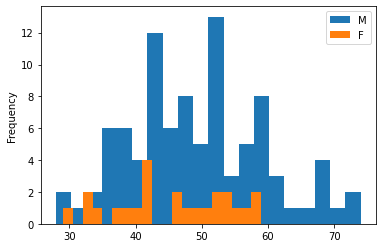

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for gender in "MF":
    gb[gb.Speaker_gender==gender].Speaker_age_at_recording.plot.hist(ax=ax, label=gender, bins=20)
plt.legend()
plt.show()

Border for men shall be 48, for women 43

In [24]:
43 in gb[gb.Speaker_gender=="F"].Speaker_age_at_recording

False

In [25]:
age_category = []
for speaker, row in gb.iterrows():
    if row["Speaker_gender"] == "M":
        if row["Speaker_age_at_recording"] >48:
            age_category.append("old")
        else:
            age_category.append("young")
    else:
        if row["Speaker_age_at_recording"] > 43:
            age_category.append("old")
        else:
            age_category.append("young")
gb["Speaker_age_group"] = age_category
gb.head()

,Count,Speaker_age_at_recording,Speaker_gender,Speaker_age_group
Speaker_name,,,,
"Đujić, Saša",2980,38.0,M,young
"Bauk, Arsen",2914,45.0,M,young
"Babić, Ante",2727,52.0,M,old
"Jovanović, Željko",2718,53.0,M,old
"Lenart, Željko",2624,50.0,M,old


In [26]:
gb["gender_age_group"] = gb.Speaker_gender + "_" + gb.Speaker_age_group

In [27]:
gb.groupby("gender_age_group").count()

,Count,Speaker_age_at_recording,Speaker_gender,Speaker_age_group
gender_age_group,,,,
F_old,13,13,13,13
F_young,11,11,11,11
M_old,46,46,46,46
M_young,47,47,47,47


In [28]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(gb.index.tolist(), stratify=gb.gender_age_group.tolist(), test_size=0.25 )

In [33]:
gb.loc[train, :].gender_age_group.value_counts()

M_young    35
M_old      34
F_old      10
F_young     8
Name: gender_age_group, dtype: int64

In [34]:
gb.loc[test, :].gender_age_group.value_counts()

M_old      12
M_young    12
F_young     3
F_old       3
Name: gender_age_group, dtype: int64

In [35]:
gb.loc[train, :].shape

(87, 5)

In [49]:
train_data = []
for speaker, row in gb.loc[train, :].iterrows():
    clips = df[df.Speaker_name == speaker].path.sample(20).values.tolist()
    for clip in clips:
        train_data.append({
            "Speaker_name": speaker,
            **row,
            "path": clip
        })

train_df = pd.DataFrame(data=train_data)

test_data = []
for speaker, row in gb.loc[test, :].iterrows():
    clips = df[df.Speaker_name == speaker].path.sample(50).values.tolist()
    for clip in clips:
        test_data.append({
            "Speaker_name": speaker,
            **row,
            "path": clip
        })

test_df = pd.DataFrame(data=test_data)


train_df

,Speaker_name,Count,Speaker_age_at_recording,Speaker_gender,Speaker_age_group,gender_age_group,path
0,"Marić, Goran",617,59.0,M,old,M_old,sR_p6PbQPeI_5344.85-5355.82.wav
1,"Marić, Goran",617,59.0,M,old,M_old,4I1CHN8ZRCA_4596.31-4613.02.wav
2,"Marić, Goran",617,59.0,M,old,M_old,MbZGxmmrF-I_8560.27-8579.93.wav
3,"Marić, Goran",617,59.0,M,old,M_old,sR_p6PbQPeI_11253.31-11272.95.wav
4,"Marić, Goran",617,59.0,M,old,M_old,MbZGxmmrF-I_7900.56-7912.7.wav
...,...,...,...,...,...,...,...
1735,"Karlić, Mladen",369,56.0,M,old,M_old,y5LrUr3SHIg_16111.59-16131.41.wav
1736,"Karlić, Mladen",369,56.0,M,old,M_old,2Z4W7McjAVw_14985.18-15004.89.wav
1737,"Karlić, Mladen",369,56.0,M,old,M_old,P_Mg7lLr7cA_21849.7-21869.64.wav
1738,"Karlić, Mladen",369,56.0,M,old,M_old,Yht1wCkxWF4_10094.0-10113.53.wav


In [50]:
test_df

,Speaker_name,Count,Speaker_age_at_recording,Speaker_gender,Speaker_age_group,gender_age_group,path
0,"Šimić, Marko",741,34.0,M,young,M_young,YaBXOzUUd-0_7053.01-7072.92.wav
1,"Šimić, Marko",741,34.0,M,young,M_young,5imR4d0-Rcc_5126.04-5143.18.wav
2,"Šimić, Marko",741,34.0,M,young,M_young,kDTIPoF6tTM_7266.79-7286.77.wav
3,"Šimić, Marko",741,34.0,M,young,M_young,fBdFnui_Ahs_16436.01-16455.7.wav
4,"Šimić, Marko",741,34.0,M,young,M_young,cWQLoS3PnTo_3994.8-4003.18.wav
...,...,...,...,...,...,...,...
1495,"Tolušić, Tomislav",371,39.0,M,young,M_young,zKanXE-Smys_4707.91-4727.29.wav
1496,"Tolušić, Tomislav",371,39.0,M,young,M_young,R7FyjGMrgsE_3245.55-3260.59.wav
1497,"Tolušić, Tomislav",371,39.0,M,young,M_young,x7iNlUeEEbs_8859.49-8871.46.wav
1498,"Tolušić, Tomislav",371,39.0,M,young,M_young,R7FyjGMrgsE_4026.14-4046.06.wav


In [52]:
files_to_move = test_df.path.tolist() + train_df.path.tolist()

with open("005_files_to_move.txt", "w") as f:
    for file in files_to_move:
        f.write(file+"\n")

test_df["path"] = test_df.path.apply(lambda s: "data_age/seg."+s)
train_df["path"] = train_df.path.apply(lambda s: "data_age/seg."+s)
test_df.to_csv("005_test.csv", index=False)
train_df.to_csv("005_train.csv", index=False)

In [53]:
train_df.head()

,Speaker_name,Count,Speaker_age_at_recording,Speaker_gender,Speaker_age_group,gender_age_group,path
0,"Marić, Goran",617,59.0,M,old,M_old,data_age/seg.sR_p6PbQPeI_5344.85-5355.82.wav
1,"Marić, Goran",617,59.0,M,old,M_old,data_age/seg.4I1CHN8ZRCA_4596.31-4613.02.wav
2,"Marić, Goran",617,59.0,M,old,M_old,data_age/seg.MbZGxmmrF-I_8560.27-8579.93.wav
3,"Marić, Goran",617,59.0,M,old,M_old,data_age/seg.sR_p6PbQPeI_11253.31-11272.95.wav
4,"Marić, Goran",617,59.0,M,old,M_old,data_age/seg.MbZGxmmrF-I_7900.56-7912.7.wav


# Preparing separate datasets for male and female speakers

In [3]:
import pandas as pd
for split in "test train".split():
    df = pd.read_csv(f"005_{split}.csv")
    df[df.Speaker_gender == "M"].to_csv(f"005_{split}_males.csv", index=False)
    df[df.Speaker_gender == "F"].to_csv(f"005_{split}_females.csv", index=False)

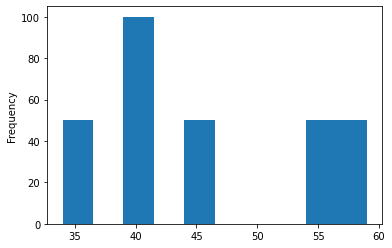

In [2]:
import pandas as pd


test = pd.read_csv("005_test_females.csv")
test.Speaker_age_at_recording.plot.hist()